# SIMPLE MOVING AVERAGE

In [16]:
import datetime
import os.path
import sys
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:


data = bt.feeds.YahooFinanceCSVData(
    dataname='oracle1995-2005.txt',
    fromdate=datetime.datetime(2000,1,1),
    todate = datetime.datetime(2000,12,31),
    reverse=False)

In [18]:
class Strat2_BGTMA_SLSMA(bt.Strategy):
    
    params = (
        ('maperiod',15), # Tuple of tuples containing any variable settings required by the strategy.
    )
    
    def __init__(self):
        self.dataclose= self.datas[0].close    # Keep a reference to the "close" line in the data[0] dataseries
        self.order = None # Property to keep track of pending orders.  There are no orders when the strategy is initialized.
        self.buyprice = None
        self.buycomm = None
        
        # Add SimpleMovingAverage indicator for use in the trading strategy
        self.sma = bt.indicators.SimpleMovingAverage( 
            self.datas[0], period=self.params.maperiod)
        
        # Add ExpMA, WtgMA, StocSlow, MACD, ATR, RSI indicators for plotting.
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,subplot = True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot = False)
    
    def log(self, txt, dt=None):
        # Logging function for the strategy.  'txt' is the statement and 'dt' can be used to specify a specific datetime
        dt = dt or self.datas[0].datetime.date(0)
        print('{0},{1}'.format(dt.isoformat(),txt))
    
    def notify_order(self, order):
        # 1. If order is submitted/accepted, do nothing 
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 2. If order is buy/sell executed, report price executed
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm: {3:8.2f}'.format(
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm{3:8.2f}'.format(
                    order.executed.price, 
                    order.executed.size, 
                    order.executed.value,
                    order.executed.comm))
            
            self.bar_executed = len(self) #when was trade executed
        # 3. If order is canceled/margin/rejected, report order canceled
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        self.order = None
    
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS {0:8.2f}, NET {1:8.2f}'.format(
            trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Log the closing prices of the series from the reference
        self.log('Close, {0:8.2f}'.format(self.dataclose[0]))

        if self.order: # check if order is pending, if so, then break out
            return
                
        # since there is no order pending, are we in the market?    
        if not self.position: # not in the market
            if self.dataclose[0] > self.sma[0]:
                self.log('BUY CREATE {0:8.2f}'.format(self.dataclose[0]))
                self.order = self.buy()           
        else: # in the market
            if self.dataclose[0] < self.sma[0]:
                self.log('SELL CREATE, {0:8.2f}'.format(self.dataclose[0]))
                self.order = self.sell()

In [19]:
cerebro = bt.Cerebro()  
cerebro.adddata(data) 
cerebro.addstrategy(Strat2_BGTMA_SLSMA, maperiod=15) 
cerebro.addsizer(bt.sizers.FixedSize,stake=10)
cerebro.broker.setcash(1000.0) 
cerebro.broker.setcommission(commission=0.0) 

In [20]:
print('Starting Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))
cerebro.run()
print('Final Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))

Starting Portfolio Value:  1000.00
2000-02-18,Close,    26.05
2000-02-22,Close,    26.38
2000-02-22,BUY CREATE    26.38
2000-02-23,BUY EXECUTED, Price:    26.77, Size:    10.00 Cost:   267.70, Comm:     0.00
2000-02-23,Close,    28.05
2000-02-24,Close,    27.55
2000-02-25,Close,    31.41
2000-02-28,Close,    30.52
2000-02-29,Close,    33.02
2000-03-01,Close,    31.80
2000-03-02,Close,    30.47
2000-03-03,Close,    33.36
2000-03-06,Close,    33.69
2000-03-07,Close,    33.33
2000-03-08,Close,    36.97
2000-03-09,Close,    37.36
2000-03-10,Close,    36.30
2000-03-13,Close,    35.02
2000-03-14,Close,    34.25
2000-03-15,Close,    34.97
2000-03-16,Close,    36.44
2000-03-17,Close,    35.50
2000-03-20,Close,    34.75
2000-03-21,Close,    35.89
2000-03-22,Close,    37.39
2000-03-23,Close,    38.64
2000-03-24,Close,    38.69
2000-03-27,Close,    39.33
2000-03-28,Close,    38.50
2000-03-29,Close,    36.69
2000-03-30,Close,    34.88
2000-03-30,SELL CREATE,    34.88
2000-03-31,SELL EXECUTED,    3

Final Portfolio Value:   982.30


<IPython.core.display.Javascript object>


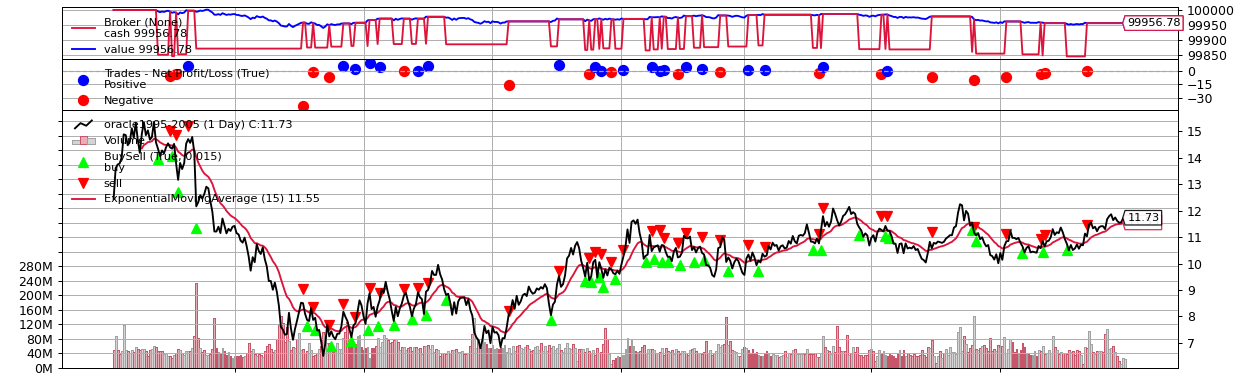

[[<Figure size 432x288 with 8 Axes>]]

In [21]:
import warnings
warnings.filterwarnings('ignore')

# this graph is of last indicator---becoz i have used only single ipynb notebook

cerebro.plot(width=100,height=200)

In [22]:
import matplotlib
matplotlib.__version__

'3.2.2'

# BOLLINGER BANDS

In [23]:

# Create a Data Feed

data = bt.feeds.YahooFinanceCSVData(
    dataname='oracle1995-2005.txt',
    fromdate=datetime.datetime(2000,1,1),
    todate = datetime.datetime(2000,12,31),

    nullvalue=0.0,

    dtformat=('%m/%d/%Y'),

    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    openinterest=-1)

In [24]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys 

# Import the backtrader platform
import backtrader as bt

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (('BBandsperiod', 20),)

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.redline = None
        self.blueline = None

        # Add a BBand indicator
        self.bband = bt.indicators.BBands(self.datas[0], period=self.params.BBandsperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        if self.dataclose < self.bband.lines.bot and not self.position:
            self.redline = True

        if self.dataclose > self.bband.lines.top and self.position:
            self.blueline = True

        if self.dataclose > self.bband.lines.mid and not self.position and self.redline:        
            # BUY, BUY, BUY!!! (with all possible default parameters)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            # Keep track of the created order to avoid a 2nd order
            self.order = self.buy()

        if self.dataclose > self.bband.lines.top and not self.position:
            # BUY, BUY, BUY!!! (with all possible default parameters)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            # Keep track of the created order to avoid a 2nd order
            self.order = self.buy()

        if self.dataclose < self.bband.lines.mid and self.position and self.blueline:
            # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            self.blueline = False
            self.redline = False
            # Keep track of the created order to avoid a 2nd order
            self.order = self.sell()

if __name__ == '__main__':
# Create a cerebro entity
    cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)



# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=5)

# Set the commission
cerebro.broker.setcommission(commission=0.002)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot()




Starting Portfolio Value: 10000.00
2000-01-31, Close, 22.22
2000-02-01, Close, 24.02
2000-02-02, Close, 24.16
2000-02-03, Close, 25.21
2000-02-04, Close, 25.71
2000-02-07, Close, 26.66
2000-02-08, Close, 26.49
2000-02-09, Close, 26.66
2000-02-10, Close, 27.71
2000-02-11, Close, 26.55
2000-02-14, Close, 27.66
2000-02-15, Close, 27.30
2000-02-16, Close, 27.24
2000-02-17, Close, 27.41
2000-02-18, Close, 26.05
2000-02-22, Close, 26.38
2000-02-23, Close, 28.05
2000-02-24, Close, 27.55
2000-02-25, Close, 31.41
2000-02-25, BUY CREATE, 31.41
2000-02-28, BUY EXECUTED, Price: 31.69, Cost: 158.45, Comm 0.32
2000-02-28, Close, 30.52
2000-02-29, Close, 33.02
2000-03-01, Close, 31.80
2000-03-02, Close, 30.47
2000-03-03, Close, 33.36
2000-03-06, Close, 33.69
2000-03-07, Close, 33.33
2000-03-08, Close, 36.97
2000-03-09, Close, 37.36
2000-03-10, Close, 36.30
2000-03-13, Close, 35.02
2000-03-14, Close, 34.25
2000-03-15, Close, 34.97
2000-03-16, Close, 36.44
2000-03-17, Close, 35.50
2000-03-20, Close, 34

[[<Figure size 432x288 with 4 Axes>]]

# RELATIVE STRENGTH INDEX

In [25]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime
import os.path
import sys
import backtrader as bt

class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=15)
        self.rsi = bt.indicators.RelativeStrengthIndex()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])
        print('rsi:', self.rsi[0])
        if self.order:
            return

        if not self.position:
            if (self.rsi[0] < 30):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy(size=500)

        else:
            if (self.rsi[0] > 70):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell(size=500)


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)
    cerebro.broker.setcommission(commission=0.001)

    
    data = bt.feeds.YahooFinanceCSVData(
        dataname='oracle1995-2005.txt',
        fromdate=datetime.datetime(2000,1,1),
        todate = datetime.datetime(2000,12,31),
         reverse=False)

    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()

Starting Portfolio Value: 100000.00
2000-01-24, Close, 24.10
rsi: 43.73918061165609
2000-01-25, Close, 25.10
rsi: 47.03079944836809
2000-01-26, Close, 24.49
rsi: 45.29010967919685
2000-01-27, Close, 23.04
rsi: 41.370419086469916
2000-01-28, Close, 21.07
rsi: 36.720552156254975
2000-01-31, Close, 22.22
rsi: 40.89672484828839
2000-02-01, Close, 24.02
rsi: 46.8133953338412
2000-02-02, Close, 24.16
rsi: 47.255659664699316
2000-02-03, Close, 25.21
rsi: 50.5751467478113
2000-02-04, Close, 25.71
rsi: 52.12043913538573
2000-02-07, Close, 26.66
rsi: 54.99931342294526
2000-02-08, Close, 26.49
rsi: 54.36931938686965
2000-02-09, Close, 26.66
rsi: 54.92534685547566
2000-02-10, Close, 27.71
rsi: 58.30482874426389
2000-02-11, Close, 26.55
rsi: 53.52989353526273
2000-02-14, Close, 27.66
rsi: 57.146482150976226
2000-02-15, Close, 27.30
rsi: 55.63420450913552
2000-02-16, Close, 27.24
rsi: 55.371202287616775
2000-02-17, Close, 27.41
rsi: 56.00579540678044
2000-02-18, Close, 26.05
rsi: 49.893569248322386


rsi: 47.26929292248373
2000-12-04, Close, 25.07
rsi: 51.70808902424666
2000-12-05, Close, 28.02
rsi: 58.814090077628336
2000-12-06, Close, 26.85
rsi: 55.33625359993932
2000-12-07, Close, 25.18
rsi: 50.725524415067596
2000-12-08, Close, 26.74
rsi: 54.536332992034154
2000-12-11, Close, 28.41
rsi: 58.258058384637394
2000-12-12, Close, 27.35
rsi: 55.170865679083114
2000-12-13, Close, 25.24
rsi: 49.542911747069304
2000-12-14, Close, 24.46
rsi: 47.60947076464899
2000-12-15, Close, 25.41
rsi: 50.16061913448648
2000-12-18, Close, 28.46
rsi: 57.34251488515155
2000-12-19, Close, 27.24
rsi: 53.99106283899356
2000-12-20, Close, 25.35
rsi: 49.19420470420521
2000-12-21, Close, 26.24
rsi: 51.38459637509177
2000-12-22, Close, 28.35
rsi: 56.205267812131694
2000-12-26, Close, 27.52
rsi: 53.939472610431764
2000-12-27, Close, 27.30
rsi: 53.32583695908677
2000-12-28, Close, 27.63
rsi: 54.168099900639774
2000-12-29, Close, 25.85
rsi: 49.02870143685403
Final Portfolio Value: 98220.31


# MOVING AVERAGE CONVERGENCE DIVERGENCE

In [26]:

import backtrader as bt
import datetime
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
class MyStrategy(bt.Strategy):
    
    params = (('period1',12), ('period2',26), ('signal_period',9))
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.macd = bt.indicators.MACD(self.data, period_me1=self.p.period1, \
                               period_me2=self.p.period2, period_signal=self.p.signal_period)
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
    
    def next(self):
        if self.order:
            return
        #Check if we are in the market
        if not self.position:
        # We are not in the market, look for a signal to OPEN trades

            #If the macd line is above the signal line
            if self.crossover > 0:
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
            #Otherwise if the macd line is below the signal line 
            elif self.crossover < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
        else:
            if self.getposition(data=self.data).size>0 and  self.crossover<0:
                self.log('Long ended, %.2f' % self.data.close[0])
                #Keep track of the created order to avoid a 2nd order
                self.order = self.close()
            elif self.getposition(data=self.data).size<0 and self.crossover>0:
                self.log('Short ended, %.2f' % self.data.close[0])  
                #Keep track of the created order to avoid a 2nd order
                self.order = self.close()
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        # Reset
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        


In [27]:
if __name__ == "__main__":
    cerebro = bt.Cerebro()
    data = bt.feeds.YahooFinanceCSVData(
        dataname = 'oracle1995-2005.txt',
        fromdate=datetime.datetime(2002, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2005, 12, 31),
        reverse=False
    )
    
    #Add data
    cerebro.adddata(data)
    #Add strategy
    cerebro.addstrategy(MyStrategy)
    #fix the size
    cerebro.addsizer(bt.sizers.SizerFix, stake=3)
    #initial investment
    cerebro.broker.setcash(100000.0)  
    #some money for the broker
    cerebro.broker.setcommission(commission=0.01)
    start_portfolio_value = cerebro.broker.getvalue()
    cerebro.run()
    end_portfolio_value = cerebro.broker.getvalue()
    print("Starting portfolio value: %s \nEnding portfolio value: %s \nPnl: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))
    cerebro.plot()

2002-02-26 BUY CREATE, 14.70
2002-02-27 BUY EXECUTED, Price: 14.87, Cost: 44.61, Comm 0.45
2002-03-04 Long ended, 12.16
2002-03-05 SELL EXECUTED, Price: 12.43, Cost: 44.61, Comm 0.37
2002-03-05 OPERATION PROFIT, GROSS -7.32, NET -8.14
2002-03-28 BUY CREATE, 11.39
2002-04-01 BUY EXECUTED, Price: 11.21, Cost: 33.63, Comm 0.34
2002-04-11 Long ended, 9.73
2002-04-12 SELL EXECUTED, Price: 9.86, Cost: 33.63, Comm 0.30
2002-04-12 OPERATION PROFIT, GROSS -4.05, NET -4.68
2002-04-16 BUY CREATE, 10.73
2002-04-17 BUY EXECUTED, Price: 10.68, Cost: 32.04, Comm 0.32
2002-04-24 Long ended, 9.34
2002-04-25 SELL EXECUTED, Price: 9.34, Cost: 32.04, Comm 0.28
2002-04-25 OPERATION PROFIT, GROSS -4.02, NET -4.62
2002-05-14 BUY CREATE, 7.84
2002-05-15 BUY EXECUTED, Price: 7.69, Cost: 23.07, Comm 0.23
2002-06-03 Long ended, 6.51
2002-06-04 SELL EXECUTED, Price: 6.64, Cost: 23.07, Comm 0.20
2002-06-04 OPERATION PROFIT, GROSS -3.15, NET -3.58
2002-06-05 BUY CREATE, 7.70
2002-06-06 BUY EXECUTED, Price: 7.52, Co

# MOVING AVERAGE CROSSOVER

In [31]:

class MAcrossover(bt.Strategy):
    
    params = (('pslow', 50), ('pfast', 20))
    
    def log(self, text, dt=None):
        dt = dt or self.data.datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
    
    def __init__(self):
        # Instantiate moving averages 
        self.fast_sma = bt.indicators.SimpleMovingAverage(period=self.params.pfast)       
        self.slow_sma = bt.indicators.SimpleMovingAverage(period=self.params.pslow)
        self.crossover = bt.indicators.CrossOver(self.fast_sma, self.slow_sma)
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        # Reset
        self.order = None
        
    def next(self):

        # Check if we are in the market
        if not self.position:
            # We are not in the market, look for a signal to OPEN trades
                
            #If the fast SMA is above the slow sma
            if self.crossover > 0:
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
            #Otherwise if the fast SMA is below the slow SMA   
            elif self.crossover < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
        else:
            if self.getposition(data=self.data).size>0 and  self.crossover<0:
                self.log('Long ended, %.2f' % self.data.close[0])
                #Keep track of the created order to avoid a 2nd order
                self.order = self.close()
            elif self.getposition(data=self.data).size<0 and self.crossover>0:
#                 print(self.getposition(data=self.data))
                self.log('Short ended, %.2f' % self.data.close[0])
                
                #Keep track of the created order to avoid a 2nd order
                self.order = self.close()


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    #Set data parameters and add to Cerebro
    data = bt.feeds.YahooFinanceCSVData(
        dataname='oracle1995-2005.txt',
        # Do not pass values before this date
        fromdate=datetime.datetime(2002, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2005, 12, 31),
        reverse=False)


    #Add data
    cerebro.adddata(data)
    #Add strategy
    cerebro.addstrategy(MAcrossover)
    #fix the size
    cerebro.addsizer(bt.sizers.SizerFix, stake=10)
    #initial investment
    cerebro.broker.setcash(100000.0)  
    #some money for the broker
    cerebro.broker.setcommission(commission=0.001)
    start_portfolio_value = cerebro.broker.getvalue()
    cerebro.run()
    end_portfolio_value = cerebro.broker.getvalue()
    print("Starting portfolio value: %s \nEnding portfolio value: %s \nPnl: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))
    cerebro.plot(width=100,height=200) 

2002-07-08 BUY CREATE, 8.28
2002-07-09 BUY EXECUTED, Price: 8.40, Cost: 84.00, Comm 0.08
2002-09-19 Long ended, 7.21
2002-09-20 SELL EXECUTED, Price: 7.28, Cost: 84.00, Comm 0.07
2002-09-20 OPERATION PROFIT, GROSS -11.20, NET -11.36
2002-10-30 BUY CREATE, 8.90
2002-10-31 BUY EXECUTED, Price: 8.87, Cost: 88.70, Comm 0.09
2003-03-05 Long ended, 9.94
2003-03-06 SELL EXECUTED, Price: 9.94, Cost: 88.70, Comm 0.10
2003-03-06 OPERATION PROFIT, GROSS 10.70, NET 10.51
2003-04-29 BUY CREATE, 10.69
2003-04-30 BUY EXECUTED, Price: 10.64, Cost: 106.40, Comm 0.11
2003-07-15 Long ended, 11.23
2003-07-16 SELL EXECUTED, Price: 11.29, Cost: 106.40, Comm 0.11
2003-07-16 OPERATION PROFIT, GROSS 6.50, NET 6.28
2003-09-03 BUY CREATE, 12.24
2003-09-04 BUY EXECUTED, Price: 12.14, Cost: 121.40, Comm 0.12
2003-10-03 Long ended, 10.66
2003-10-06 SELL EXECUTED, Price: 10.74, Cost: 121.40, Comm 0.11
2003-10-06 OPERATION PROFIT, GROSS -14.00, NET -14.23
2003-11-17 BUY CREATE, 10.75
2003-11-18 BUY EXECUTED, Price: 1

# EXPONENT MOVING AVERAGE

In [32]:

class MyStrategy(bt.Strategy):
    
    params = (('period',15),)
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.ema = bt.indicators.ExponentialMovingAverage(self.data, period=self.p.period)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        # Reset
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data.close[0]<self.ema:
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        else:
            if self.data.close[0]>self.ema:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [33]:
if __name__ == "__main__":
    cerebro = bt.Cerebro()
    data = bt.feeds.YahooFinanceCSVData(
        dataname = 'oracle1995-2005.txt',
        fromdate=datetime.datetime(2002, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2003, 12, 31),
        reverse=False
    )
    
    #Add data
    cerebro.adddata(data)
    #Add strategy
    cerebro.addstrategy(MyStrategy)
    #fix the size
    cerebro.addsizer(bt.sizers.SizerFix, stake=10)
    #initial investment
    cerebro.broker.setcash(100000.0)  
    #some money for the broker
    cerebro.broker.setcommission(commission=0.01)
    start_portfolio_value = cerebro.broker.getvalue()
    cerebro.run()
    end_portfolio_value = cerebro.broker.getvalue()
    print("Starting portfolio value: %s \nEnding portfolio value: %s \nPnl: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))
    cerebro.plot()

2002-02-01 BUY CREATE, 14.58
2002-02-04 BUY EXECUTED, Price: 14.62, Cost: 146.20, Comm 1.46
2002-02-11 SELL CREATE, 14.54
2002-02-12 SELL EXECUTED, Price: 14.39, Cost: 146.20, Comm 1.44
2002-02-12 OPERATION PROFIT, GROSS -2.30, NET -5.20
2002-02-12 BUY CREATE, 14.39
2002-02-13 BUY EXECUTED, Price: 14.57, Cost: 145.70, Comm 1.46
2002-02-14 SELL CREATE, 14.52
2002-02-15 SELL EXECUTED, Price: 14.56, Cost: 145.70, Comm 1.46
2002-02-15 OPERATION PROFIT, GROSS -0.10, NET -3.01
2002-02-15 BUY CREATE, 13.78
2002-02-19 BUY EXECUTED, Price: 13.64, Cost: 136.40, Comm 1.36
2002-02-25 SELL CREATE, 14.53
2002-02-26 SELL EXECUTED, Price: 14.53, Cost: 136.40, Comm 1.45
2002-02-26 OPERATION PROFIT, GROSS 8.90, NET 6.08
2002-03-01 BUY CREATE, 14.22
2002-03-04 BUY EXECUTED, Price: 12.41, Cost: 124.10, Comm 1.24
2002-05-16 SELL CREATE, 8.52
2002-05-17 SELL EXECUTED, Price: 8.69, Cost: 124.10, Comm 0.87
2002-05-17 OPERATION PROFIT, GROSS -37.20, NET -39.31
2002-05-20 BUY CREATE, 8.10
2002-05-21 BUY EXECUTE